In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import time

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import pytorch_lightning as pl

import sklearn
import functools
import operator

import sys

import optuna

sys.path.insert(1,"/home/sbulusu/qcd_ml/neural_networks/libs/")

#import lat_dataset_load_new_lightning
import open_worm_lat_dataset_load_new_lightning_dat
#import struct_torch_net_class_lightning
import custom_torch_net_class_lightning

import utils

from tqdm.notebook import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Utilizing CUDA")
else:
    device = torch.device("cpu")
    print("Utilizing CPU")

Utilizing CUDA


In [3]:
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [4]:
pickle_file = open("study.pickle", "rb")
study = pickle.load(pickle_file)
study.best_params

{'lr': 7.997160135530374e-05, 'bs': 16}

In [5]:
study.best_trial

FrozenTrial(number=3, value=0.03698612377047539, datetime_start=datetime.datetime(2020, 6, 11, 18, 56, 39, 945901), datetime_complete=datetime.datetime(2020, 6, 11, 19, 49, 15, 266537), params={'lr': 7.997160135530374e-05, 'bs': 16}, distributions={'lr': LogUniformDistribution(high=0.0001, low=1e-07), 'bs': CategoricalDistribution(choices=(16, 32, 64, 128))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.90497887134552, 1: 1.2433934211730957, 2: 1.173068881034851, 3: 1.2811923027038574, 4: 1.2866417169570923, 5: 1.2391749620437622, 6: 1.0721021890640259, 7: 1.0520248413085938, 8: 1.0401575565338135, 9: 1.0229144096374512, 10: 0.5568913221359253, 11: 0.7357636094093323, 12: 0.02683534286916256, 13: 0.5797433257102966, 14: 0.7524706721305847, 15: 0.02300507202744484, 16: 0.051136452704668045, 17: 0.6087241768836975, 18: 0.08087282627820969, 19: 0.014240356162190437, 20: 0.01453562080860138, 21: 0.00867779552936554, 22: 0.006722892168909311, 23: 0.0045278118923306465, 24: 0.00

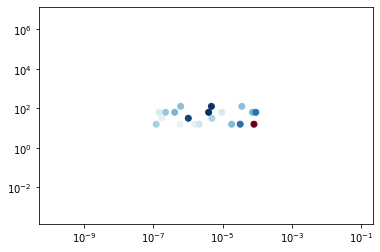

In [6]:
trial_coords = np.zeros((len(study.trials),2))

trial_metrics = np.zeros((len(study.trials)))

for trial_i, trial in enumerate(study.trials):
    par_i = 0
    for par_name in trial.params:
        trial_coords[trial_i, par_i] = trial.params[par_name]
        trial_metrics[trial_i] = trial.value
        par_i +=1

#fig, ax = plt.figure()
#ax.scatter(trial_coords[:,0], trial_coords[:,1], c=trial_metrics, cmap="RdBu")

#ax.set_scale("log")
plt.xscale("log")
plt.yscale("log")
plt.scatter(trial_coords[:,0], trial_coords[:,1], c=trial_metrics, cmap="RdBu")

In [7]:
checkpoint_path = "pl_checkpoints/CustomNet-003-epoch=178-val_loss=1.51679E-08.ckpt"

In [8]:
#best_model = custom_torch_net_class_lightning.CustomNet.load_from_checkpoint(checkpoint_path,hyper_parameters)
best_model = custom_torch_net_class_lightning.CustomNet.load_from_checkpoint(checkpoint_path)

best_model.to(device)

best_model.configure_loss()

best_model.eval()

CustomNet(
  (cnn): Net(
    (layers): ModuleList(
      (0): AsymmetricCircularPadding()
      (1): Conv2d(4, 64, kernel_size=[2, 2], stride=[1, 1])
      (2): ReLU()
      (3): AsymmetricCircularPadding()
      (4): Conv2d(64, 64, kernel_size=[2, 2], stride=[1, 1])
      (5): ReLU()
      (6): AsymmetricCircularPadding()
      (7): Conv2d(64, 64, kernel_size=[2, 2], stride=[1, 1])
      (8): ReLU()
      (9): AdaptiveAvgPool2d(output_size=[1, 1])
      (10): ReLU()
    )
  )
  (dense1): Net(
    (layers): ModuleList(
      (0): Reshape()
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (loss): BCELoss()
)

In [9]:
"""
Load Data
"""
#conf_file_dir = "/media/data/sbulusu/datasets/complexworm/dat_files/"
conf_file_dir = "/media/data/sbulusu/datasets/complexworm/dat_files/"
file_format_list = ["Multi_lattice_open_worms/open_configs-100-5*.dat",
                    "Multi_lattice_closed_worms/configs-100-5*.dat"
                   ]

#label_names = ["n", "phi2"]
label_names = []
labels_in_file_name = ["nt", "nx", "eta", "lambda", "mu"]

dataset = open_worm_lat_dataset_load_new_lightning_dat.kl_dataset(conf_file_dir, file_format_list,
                                                              label_names, labels_in_file_name,
                                                              transform=None)

found file 58 paths:
['/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.995.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.030.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.990.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.040.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.000.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.015.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.005.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.940.dat', '/media/data/sbulu

Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.995.dat
['open_configs', '100', '5', '4.010', '1.000', '0.995']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.995.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.995.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs


first example loaded:
{'conf': tensor([[[ 1,  1,  1,  ...,  2,  2,  1],
         [ 0,  0,  0,  ...,  0, -1,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ..., -1, -1,  1],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  2,  2,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  1,  0]],

        [[ 0,  0,  1,  ...,  0,  1,  1],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  1,  ...,  0,  0,  1],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]]]), 'mu': 0.995, 'open': True, 'nt': 100.0, 'nx': 5.0, 'eta': 4.01, 'lambda': 1.0, 'phase': tensor(1.), 'id': 0}

Processing conf file /media/da


Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.990.dat
['open_configs', '100', '5', '4.010', '1.000', '0.990']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.990.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.990.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.040.dat
['open_configs', '100', '5', '4.010', '1.000', '1.040']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.040.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.040.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.000.dat
['open_configs', '100', '5', '4.010', '1.000', '1.000']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.000.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.000.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.015.dat
['open_configs', '100', '5', '4.010', '1.000', '1.015']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.015.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.015.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.005.dat
['open_configs', '100', '5', '4.010', '1.000', '1.005']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.005.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.005.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.940.dat
['open_configs', '100', '5', '4.010', '1.000', '0.940']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.940.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.940.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.035.dat
['open_configs', '100', '5', '4.010', '1.000', '1.035']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.035.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.035.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.935.dat
['open_configs', '100', '5', '4.010', '1.000', '0.935']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.935.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.935.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.975.dat
['open_configs', '100', '5', '4.010', '1.000', '0.975']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.975.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.975.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.950.dat
['open_configs', '100', '5', '4.010', '1.000', '0.950']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.950.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.950.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.045.dat
['open_configs', '100', '5', '4.010', '1.000', '1.045']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.045.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.045.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.050.dat
['open_configs', '100', '5', '4.010', '1.000', '1.050']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.050.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.050.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.010.dat
['open_configs', '100', '5', '4.010', '1.000', '1.010']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.010.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.010.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.910.dat
['open_configs', '100', '5', '4.010', '1.000', '0.910']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.910.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.910.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.955.dat
['open_configs', '100', '5', '4.010', '1.000', '0.955']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.955.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.955.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.920.dat
['open_configs', '100', '5', '4.010', '1.000', '0.920']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.920.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.920.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.930.dat
['open_configs', '100', '5', '4.010', '1.000', '0.930']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.930.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.930.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.985.dat
['open_configs', '100', '5', '4.010', '1.000', '0.985']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.985.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.985.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.965.dat
['open_configs', '100', '5', '4.010', '1.000', '0.965']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.965.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.965.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.020.dat
['open_configs', '100', '5', '4.010', '1.000', '1.020']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.020.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.020.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.915.dat
['open_configs', '100', '5', '4.010', '1.000', '0.915']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.915.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.915.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.925.dat
['open_configs', '100', '5', '4.010', '1.000', '0.925']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.925.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.925.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.960.dat
['open_configs', '100', '5', '4.010', '1.000', '0.960']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.960.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.960.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.980.dat
['open_configs', '100', '5', '4.010', '1.000', '0.980']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.980.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.980.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.970.dat
['open_configs', '100', '5', '4.010', '1.000', '0.970']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.970.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.970.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.025.dat
['open_configs', '100', '5', '4.010', '1.000', '1.025']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.025.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-1.025.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.945.dat
['open_configs', '100', '5', '4.010', '1.000', '0.945']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.945.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-100-5-4.010-1.000-0.945.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.050.dat
['configs', '100', '5', '4.010', '1.000', '1.050']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.050.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.050.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.975.dat
['configs', '100', '5', '4.010', '1.000', '0.975']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.975.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.975.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.955.dat
['configs', '100', '5', '4.010', '1.000', '0.955']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.955.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.955.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.990.dat
['configs', '100', '5', '4.010', '1.000', '0.990']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.990.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.990.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.970.dat
['configs', '100', '5', '4.010', '1.000', '0.970']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.970.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.970.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.045.dat
['configs', '100', '5', '4.010', '1.000', '1.045']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.045.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.045.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.005.dat
['configs', '100', '5', '4.010', '1.000', '1.005']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.005.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.005.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.980.dat
['configs', '100', '5', '4.010', '1.000', '0.980']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.980.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.980.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.040.dat
['configs', '100', '5', '4.010', '1.000', '1.040']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.040.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.040.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.030.dat
['configs', '100', '5', '4.010', '1.000', '1.030']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.030.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.030.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.015.dat
['configs', '100', '5', '4.010', '1.000', '1.015']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.015.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.015.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.940.dat
['configs', '100', '5', '4.010', '1.000', '0.940']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.940.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.940.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.010.dat
['configs', '100', '5', '4.010', '1.000', '1.010']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.010.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.010.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.000.dat
['configs', '100', '5', '4.010', '1.000', '1.000']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.000.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.000.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.915.dat
['configs', '100', '5', '4.010', '1.000', '0.915']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.915.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.915.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.025.dat
['configs', '100', '5', '4.010', '1.000', '1.025']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.025.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.025.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.950.dat
['configs', '100', '5', '4.010', '1.000', '0.950']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.950.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.950.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.930.dat
['configs', '100', '5', '4.010', '1.000', '0.930']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.930.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.930.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.960.dat
['configs', '100', '5', '4.010', '1.000', '0.960']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.960.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.960.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.925.dat
['configs', '100', '5', '4.010', '1.000', '0.925']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.925.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.925.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.995.dat
['configs', '100', '5', '4.010', '1.000', '0.995']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.995.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.995.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.020.dat
['configs', '100', '5', '4.010', '1.000', '1.020']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.020.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.020.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.985.dat
['configs', '100', '5', '4.010', '1.000', '0.985']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.985.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.985.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.910.dat
['configs', '100', '5', '4.010', '1.000', '0.910']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.910.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.910.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.035.dat
['configs', '100', '5', '4.010', '1.000', '1.035']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.035.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-1.035.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.945.dat
['configs', '100', '5', '4.010', '1.000', '0.945']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.945.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.945.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.965.dat
['configs', '100', '5', '4.010', '1.000', '0.965']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.965.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.965.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.935.dat
['configs', '100', '5', '4.010', '1.000', '0.935']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.935.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.935.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.920.dat
['configs', '100', '5', '4.010', '1.000', '0.920']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.920.dat with size :torch.Size([4000, 4, 5, 100])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-100-5-4.010-1.000-0.920.dat with size :torch.Size([4000, 4, 5, 100])
Loading 4000 confs




last example loaded:
{'conf': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 0, 0]]]), 'mu': 0.92, 'open': False, 'nt': 100.0, 'nx': 5.0, 'eta': 4.01, 'lambda': 1.0, 'phase': tensor(0.), 'id': 231999}


In [10]:
target_attributes = ["open"]
output_attributes = target_attributes

dataset.train_label_names = target_attributes

In [11]:
net = best_model

In [12]:
lat_size = dataset[0][0].size()[1:]

In [13]:
new_data_len = len(dataset)
test_indices = list(range(new_data_len))

lat_size = dataset[0][0].size()[1:]

"""
Load Test Data
"""
net = best_model
net.eval()
print(f"test dataset size: {len(test_indices)}")
#lat_size = [10,200]
input_size = net.input_size
output_size = net.output_size
model_input_shape = tuple(np.concatenate(([-1],input_size)))
print(model_input_shape)

#net_outputs = np.zeros( (len(test_indices)) )
net_outputs = np.zeros( (len(test_indices), len(output_attributes)) )
#labels = np.zeros( (len(test_indices)) )
labels = np.zeros( (len(test_indices), len(output_attributes)) )
mus = np.zeros( (len(test_indices)) )

with torch.no_grad():
    for i in tqdm(range(len(test_indices))):
    #for i in tqdm(range(len(val_indices))):

        test_index = test_indices[i]
        conf_lat_links, label = dataset[test_index]
        batch_conf_lat_links = torch.zeros(1, *conf_lat_links.size())
        batch_conf_lat_links[0] = conf_lat_links
        mus[i] = dataset.data[test_index]["mu"]
        #net_outputs[i] = net(conf_lat_links.view(model_input_shape).to(device).float()).detach().cpu().numpy()
        #net_outputs[i] = net(conf_lat_links.to(device).float()).detach().cpu().numpy()
        net_outputs[i] = net(batch_conf_lat_links.to(device).float()).detach().cpu().numpy()
        #output = net(conf_lat_links.view(model_input_shape).float())
        #labels[i] = label.detach().cpu().numpy()
        labels[i] = np.array(label)
 

test dataset size: 232000
(-1, 1)


In [14]:
labels = labels.flatten()
net_outputs = net_outputs.flatten()

In [15]:
dev = np.abs(net_outputs - labels)
print(dev.sum())

110055.02699001516


In [16]:
int_net_outputs = np.rint(net_outputs)
int_dev = np.abs(int_net_outputs - labels.astype(int))
#print(int_dev.sum())

In [17]:
labels.shape

(232000,)

In [18]:
results = pd.DataFrame(np.transpose([labels.flatten(), int_net_outputs.flatten()]))

In [19]:
results

,0,1
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
231995,0.0,1.0
231996,0.0,1.0
231997,0.0,1.0
231998,0.0,1.0


In [20]:
results.describe()

,0,1
count,232000.000000,232000.000000
mean,0.500000,0.975276
std,0.500001,0.155283
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.500000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [21]:
pd_labels = pd.Series(labels.flatten(), name="Label")
pd_int_net_outputs = pd.Series(int_net_outputs.flatten(), name="Pred")
pd.crosstab(pd_labels, pd_int_net_outputs)

Pred,0.0,1.0
Label,,
0.0,5697,110303
1.0,39,115961


In [22]:
print(f"lat_size {lat_size}")
for i in range(len(target_attributes)):
    print(f"misclassifications")
    print(np.sum(int_dev))

lat_size torch.Size([5, 100])
misclassifications
110342.0


[[  5697 110303]
 [    39 115961]]


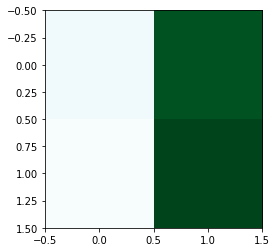

In [23]:
 """confmat"""
import sklearn as sk

conf_mat = sk.metrics.confusion_matrix(labels, int_net_outputs)
#conf_mat = conf_mat/len(labels)
print(conf_mat)
plt.imshow(conf_mat, cmap="BuGn")

In [24]:
 """confmat per mu"""

'confmat per mu'

In [25]:
unique_mus = np.unique(mus)
num_mus = len(unique_mus)
print(num_mus)

29


In [26]:
mu_labels = []
mu_int_net_outputs = []
mu_conf_mats = []

In [27]:
for mu_val in unique_mus:
    mu_loc = np.where(mus == mu_val)[0]
    
    mu_label = labels[mu_loc]
    mu_int_net_output = int_net_outputs[mu_loc]
    
    mu_labels.append(mu_label)
    mu_int_net_outputs.append(mu_int_net_output)
    mu_conf_mat = sk.metrics.confusion_matrix(mu_label, mu_int_net_output)
    mu_conf_mats.append(mu_conf_mat)
    
for mu_i in range(num_mus):
    print(mu_conf_mats[mu_i])
    print("\n")

[[ 815 3185]
 [   5 3995]]


[[ 849 3151]
 [   3 3997]]


[[ 785 3215]
 [  12 3988]]


[[ 689 3311]
 [   1 3999]]


[[ 617 3383]
 [   6 3994]]


[[ 580 3420]
 [   6 3994]]


[[ 373 3627]
 [   1 3999]]


[[ 321 3679]
 [   0 4000]]


[[ 240 3760]
 [   4 3996]]


[[ 154 3846]
 [   0 4000]]


[[ 101 3899]
 [   0 4000]]


[[  87 3913]
 [   1 3999]]


[[  40 3960]
 [   0 4000]]


[[  12 3988]
 [   0 4000]]


[[  10 3990]
 [   0 4000]]


[[  14 3986]
 [   0 4000]]


[[   3 3997]
 [   0 4000]]


[[   0 4000]
 [   0 4000]]


[[   0 4000]
 [   0 4000]]


[[   0 4000]
 [   0 4000]]


[[   1 3999]
 [   0 4000]]


[[   1 3999]
 [   0 4000]]


[[   1 3999]
 [   0 4000]]


[[   1 3999]
 [   0 4000]]


[[   1 3999]
 [   0 4000]]


[[   0 4000]
 [   0 4000]]


[[   0 4000]
 [   0 4000]]


[[   2 3998]
 [   0 4000]]


[[   0 4000]
 [   0 4000]]




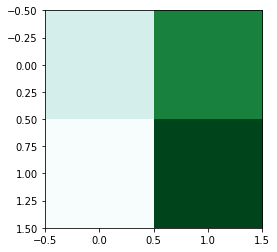

In [28]:
plt.imshow(mu_conf_mats[1], cmap="BuGn")

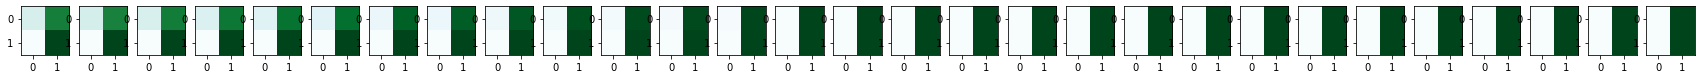

In [29]:
plt.rcParams['figure.figsize'] = [30, 20]
fig, ax = plt.subplots(nrows=1, ncols=num_mus)

for i in range(len(ax)):
    ax[i].imshow(mu_conf_mats[i], cmap="BuGn")
    

In [30]:
"""
Load Data
"""
#conf_file_dir = "/media/data/sbulusu/datasets/complexworm/dat_files/"
conf_file_dir = "/media/data/sbulusu/datasets/complexworm/dat_files/"
file_format_list = ["Multi_lattice_open_worms/open_configs-125-8*.dat",
                    "Multi_lattice_closed_worms/configs-125-8*.dat"
                   ]

#label_names = ["n", "phi2"]
label_names = []
labels_in_file_name = ["nt", "nx", "eta", "lambda", "mu"]

dataset = open_worm_lat_dataset_load_new_lightning_dat.kl_dataset(conf_file_dir, file_format_list,
                                                              label_names, labels_in_file_name,
                                                              transform=None)

found file 58 paths:
['/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.035.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.970.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.930.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.975.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.950.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.945.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.040.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.990.dat', '/media/data/sbulu

Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.035.dat
['open_configs', '125', '8', '4.010', '1.000', '1.035']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.035.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.035.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs


first example loaded:
{'conf': tensor([[[ 0,  0,  0,  ...,  2,  0,  0],
         [ 0,  0,  0,  ...,  0,  1,  1],
         [ 1,  1,  2,  ...,  0,  1,  1],
         ...,
         [ 2,  1,  1,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  1,  1,  0]],

        [[ 0,  0,  0,  ..., -1,  2,  0],
         [ 1,  0,  0,  ..., -1,  1,  0],
         [ 1,  0, -1,  ..., -1,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0, -1],
         [ 0,  0,  0,  ...,  0,  0, -1],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  1,  1,  ...,  0,  0,  1],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
     


Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.930.dat
['open_configs', '125', '8', '4.010', '1.000', '0.930']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.930.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.930.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.975.dat
['open_configs', '125', '8', '4.010', '1.000', '0.975']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.975.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.975.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.950.dat
['open_configs', '125', '8', '4.010', '1.000', '0.950']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.950.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.950.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.945.dat
['open_configs', '125', '8', '4.010', '1.000', '0.945']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.945.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.945.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.040.dat
['open_configs', '125', '8', '4.010', '1.000', '1.040']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.040.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.040.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.990.dat
['open_configs', '125', '8', '4.010', '1.000', '0.990']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.990.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.990.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.045.dat
['open_configs', '125', '8', '4.010', '1.000', '1.045']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.045.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.045.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.960.dat
['open_configs', '125', '8', '4.010', '1.000', '0.960']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.960.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.960.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.995.dat
['open_configs', '125', '8', '4.010', '1.000', '0.995']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.995.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.995.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.005.dat
['open_configs', '125', '8', '4.010', '1.000', '1.005']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.005.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.005.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.020.dat
['open_configs', '125', '8', '4.010', '1.000', '1.020']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.020.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.020.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.000.dat
['open_configs', '125', '8', '4.010', '1.000', '1.000']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.000.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.000.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.015.dat
['open_configs', '125', '8', '4.010', '1.000', '1.015']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.015.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.015.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.910.dat
['open_configs', '125', '8', '4.010', '1.000', '0.910']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.910.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.910.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.955.dat
['open_configs', '125', '8', '4.010', '1.000', '0.955']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.955.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.955.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.010.dat
['open_configs', '125', '8', '4.010', '1.000', '1.010']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.010.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.010.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.025.dat
['open_configs', '125', '8', '4.010', '1.000', '1.025']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.025.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.025.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.920.dat
['open_configs', '125', '8', '4.010', '1.000', '0.920']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.920.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.920.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.940.dat
['open_configs', '125', '8', '4.010', '1.000', '0.940']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.940.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.940.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.925.dat
['open_configs', '125', '8', '4.010', '1.000', '0.925']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.925.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.925.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.985.dat
['open_configs', '125', '8', '4.010', '1.000', '0.985']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.985.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.985.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.935.dat
['open_configs', '125', '8', '4.010', '1.000', '0.935']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.935.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.935.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.050.dat
['open_configs', '125', '8', '4.010', '1.000', '1.050']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.050.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.050.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.980.dat
['open_configs', '125', '8', '4.010', '1.000', '0.980']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.980.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.980.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.030.dat
['open_configs', '125', '8', '4.010', '1.000', '1.030']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.030.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-1.030.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.915.dat
['open_configs', '125', '8', '4.010', '1.000', '0.915']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.915.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.915.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.965.dat
['open_configs', '125', '8', '4.010', '1.000', '0.965']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.965.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-125-8-4.010-1.000-0.965.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.025.dat
['configs', '125', '8', '4.010', '1.000', '1.025']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.025.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.025.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.015.dat
['configs', '125', '8', '4.010', '1.000', '1.015']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.015.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.015.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.935.dat
['configs', '125', '8', '4.010', '1.000', '0.935']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.935.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.935.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.950.dat
['configs', '125', '8', '4.010', '1.000', '0.950']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.950.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.950.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.965.dat
['configs', '125', '8', '4.010', '1.000', '0.965']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.965.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.965.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.940.dat
['configs', '125', '8', '4.010', '1.000', '0.940']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.940.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.940.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.970.dat
['configs', '125', '8', '4.010', '1.000', '0.970']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.970.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.970.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.995.dat
['configs', '125', '8', '4.010', '1.000', '0.995']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.995.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.995.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.010.dat
['configs', '125', '8', '4.010', '1.000', '1.010']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.010.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.010.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.040.dat
['configs', '125', '8', '4.010', '1.000', '1.040']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.040.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.040.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.960.dat
['configs', '125', '8', '4.010', '1.000', '0.960']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.960.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.960.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.915.dat
['configs', '125', '8', '4.010', '1.000', '0.915']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.915.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.915.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.990.dat
['configs', '125', '8', '4.010', '1.000', '0.990']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.990.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.990.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.030.dat
['configs', '125', '8', '4.010', '1.000', '1.030']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.030.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.030.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.005.dat
['configs', '125', '8', '4.010', '1.000', '1.005']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.005.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.005.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.975.dat
['configs', '125', '8', '4.010', '1.000', '0.975']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.975.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.975.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.000.dat
['configs', '125', '8', '4.010', '1.000', '1.000']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.000.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.000.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.910.dat
['configs', '125', '8', '4.010', '1.000', '0.910']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.910.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.910.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.045.dat
['configs', '125', '8', '4.010', '1.000', '1.045']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.045.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.045.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.020.dat
['configs', '125', '8', '4.010', '1.000', '1.020']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.020.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.020.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.980.dat
['configs', '125', '8', '4.010', '1.000', '0.980']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.980.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.980.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.985.dat
['configs', '125', '8', '4.010', '1.000', '0.985']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.985.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.985.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.955.dat
['configs', '125', '8', '4.010', '1.000', '0.955']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.955.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.955.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.930.dat
['configs', '125', '8', '4.010', '1.000', '0.930']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.930.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.930.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.920.dat
['configs', '125', '8', '4.010', '1.000', '0.920']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.920.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.920.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.945.dat
['configs', '125', '8', '4.010', '1.000', '0.945']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.945.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.945.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.925.dat
['configs', '125', '8', '4.010', '1.000', '0.925']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.925.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-0.925.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.050.dat
['configs', '125', '8', '4.010', '1.000', '1.050']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.050.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.050.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.035.dat
['configs', '125', '8', '4.010', '1.000', '1.035']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.035.dat with size :torch.Size([4000, 4, 8, 125])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-125-8-4.010-1.000-1.035.dat with size :torch.Size([4000, 4, 8, 125])
Loading 4000 confs




last example loaded:
{'conf': tensor([[[ 1,  2,  1,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  1,  1,  ...,  1,  0,  1],
         ...,
         [ 1,  0,  0,  ...,  1,  2,  1],
         [ 1,  1,  0,  ...,  1,  1,  1],
         [ 0, -1,  0,  ...,  0,  0,  1]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 1, -1,  0,  ...,  0,  1, -1],
         ...,
         [ 0,  0, -1,  ...,  0,  0,  1],
         [ 0,  0,  0,  ...,  0,  0,  1],
         [ 1,  1, -1,  ...,  0,  0,  0]],

        [[ 0,  1,  0,  ...,  0,  1,  0],
         [ 0,  0,  1,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 1,  0,  1,  ...,  2,  0,  1],
         [ 0,  0,  0,  ...,  1,  0,  0],
         [ 1,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  1],
         [ 0,  0,  0,  ...,  0,  0,  1],
         [ 1,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
    

In [31]:
target_attributes = ["open"]
output_attributes = target_attributes

dataset.train_label_names = target_attributes

In [32]:
net = best_model

In [33]:
lat_size = dataset[0][0].size()[1:]

In [34]:
new_data_len = len(dataset)
test_indices = list(range(new_data_len))

lat_size = dataset[0][0].size()[1:]

"""
Load Test Data
"""
net = best_model
net.eval()
print(f"test dataset size: {len(test_indices)}")
#lat_size = [10,200]
input_size = net.input_size
output_size = net.output_size
model_input_shape = tuple(np.concatenate(([-1],input_size)))
print(model_input_shape)

#net_outputs = np.zeros( (len(test_indices)) )
net_outputs = np.zeros( (len(test_indices), len(output_attributes)) )
#labels = np.zeros( (len(test_indices)) )
labels = np.zeros( (len(test_indices), len(output_attributes)) )
mus = np.zeros( (len(test_indices)) )

with torch.no_grad():
    for i in tqdm(range(len(test_indices))):
    #for i in tqdm(range(len(val_indices))):

        test_index = test_indices[i]
        conf_lat_links, label = dataset[test_index]
        batch_conf_lat_links = torch.zeros(1, *conf_lat_links.size())
        batch_conf_lat_links[0] = conf_lat_links
        mus[i] = dataset.data[test_index]["mu"]
        #net_outputs[i] = net(conf_lat_links.view(model_input_shape).to(device).float()).detach().cpu().numpy()
        #net_outputs[i] = net(conf_lat_links.to(device).float()).detach().cpu().numpy()
        net_outputs[i] = net(batch_conf_lat_links.to(device).float()).detach().cpu().numpy()
        #output = net(conf_lat_links.view(model_input_shape).float())
        #labels[i] = label.detach().cpu().numpy()
        labels[i] = np.array(label)
 

test dataset size: 232000
(-1, 1)


In [35]:
labels = labels.flatten()
net_outputs = net_outputs.flatten()

In [36]:
dev = np.abs(net_outputs - labels)
print(dev.sum())

111331.41527277185


In [37]:
int_net_outputs = np.rint(net_outputs)
int_dev = np.abs(int_net_outputs - labels.astype(int))
#print(int_dev.sum())

In [38]:
labels.shape

(232000,)

In [39]:
results = pd.DataFrame(np.transpose([labels.flatten(), int_net_outputs.flatten()]))

In [40]:
results

,0,1
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
231995,0.0,1.0
231996,0.0,1.0
231997,0.0,1.0
231998,0.0,1.0


In [41]:
results.describe()

,0,1
count,232000.000000,232000.000000
mean,0.500000,0.979207
std,0.500001,0.142691
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.500000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [42]:
pd_labels = pd.Series(labels.flatten(), name="Label")
pd_int_net_outputs = pd.Series(int_net_outputs.flatten(), name="Pred")
pd.crosstab(pd_labels, pd_int_net_outputs)

Pred,0.0,1.0
Label,,
0.0,4750,111250
1.0,74,115926


In [43]:
print(f"lat_size {lat_size}")
for i in range(len(target_attributes)):
    print(f"misclassifications")
    print(np.sum(int_dev))

lat_size torch.Size([8, 125])
misclassifications
111324.0


[[  4750 111250]
 [    74 115926]]


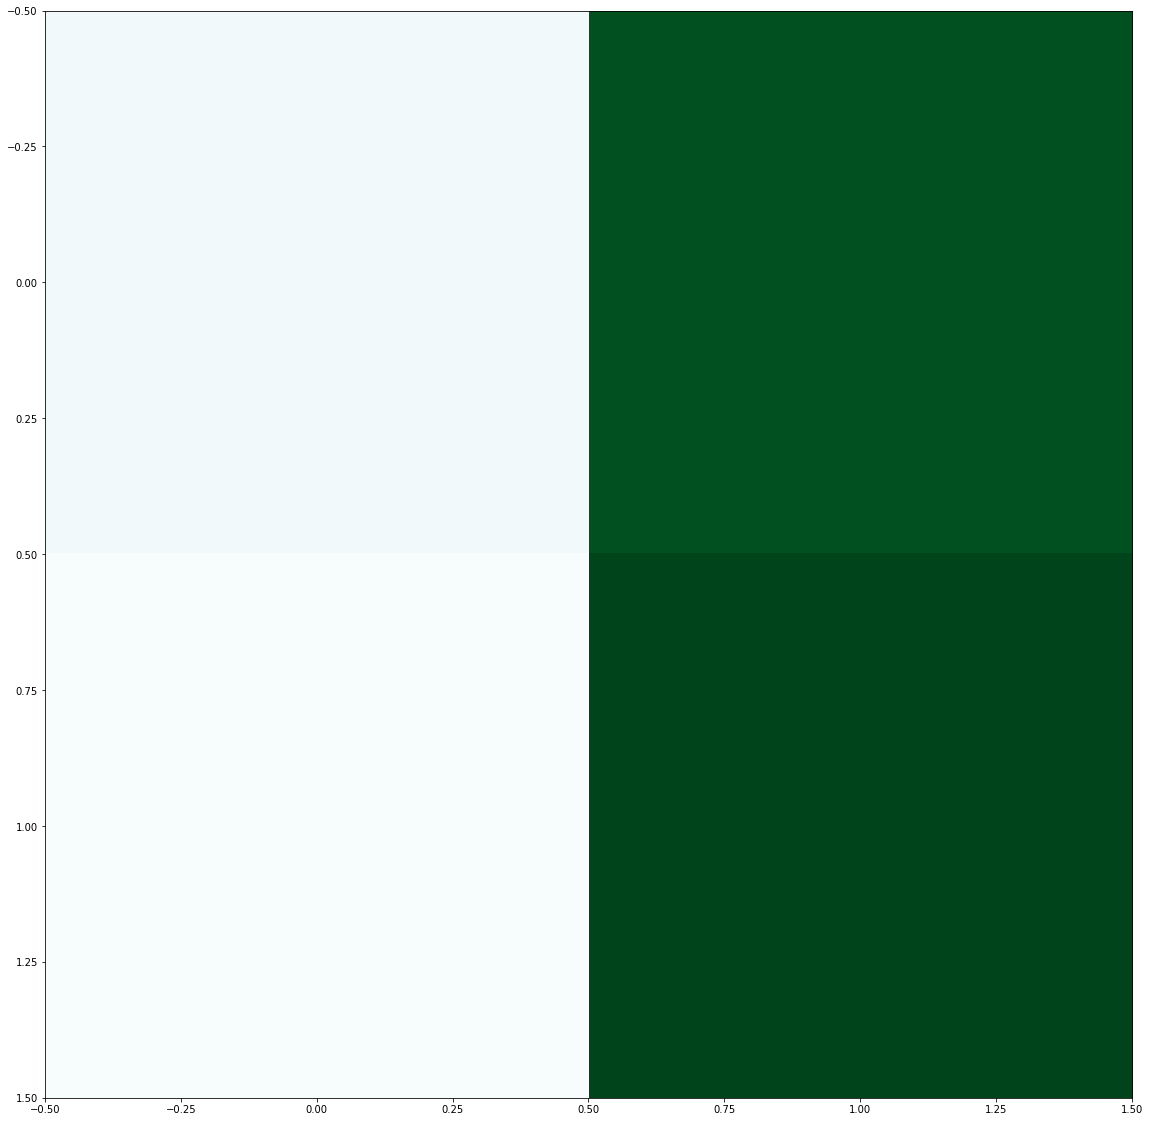

In [44]:
 """confmat"""
import sklearn as sk

conf_mat = sk.metrics.confusion_matrix(labels, int_net_outputs)
#conf_mat = conf_mat/len(labels)
print(conf_mat)
plt.imshow(conf_mat, cmap="BuGn")

In [45]:
 """confmat per mu"""

'confmat per mu'

In [46]:
unique_mus = np.unique(mus)
num_mus = len(unique_mus)
print(num_mus)

29


In [47]:
mu_labels = []
mu_int_net_outputs = []
mu_conf_mats = []

In [48]:
for mu_val in unique_mus:
    mu_loc = np.where(mus == mu_val)[0]
    
    mu_label = labels[mu_loc]
    mu_int_net_output = int_net_outputs[mu_loc]
    
    mu_labels.append(mu_label)
    mu_int_net_outputs.append(mu_int_net_output)
    mu_conf_mat = sk.metrics.confusion_matrix(mu_label, mu_int_net_output)
    mu_conf_mats.append(mu_conf_mat)
    
for mu_i in range(num_mus):
    print(mu_conf_mats[mu_i])
    print("\n")

[[ 764 3236]
 [  18 3982]]


[[ 756 3244]
 [  10 3990]]


[[ 680 3320]
 [  20 3980]]


[[ 701 3299]
 [   8 3992]]


[[ 594 3406]
 [   1 3999]]


[[ 449 3551]
 [   5 3995]]


[[ 292 3708]
 [   8 3992]]


[[ 233 3767]
 [   1 3999]]


[[ 129 3871]
 [   0 4000]]


[[  72 3928]
 [   3 3997]]


[[  42 3958]
 [   0 4000]]


[[   9 3991]
 [   0 4000]]


[[   8 3992]
 [   0 4000]]


[[   3 3997]
 [   0 4000]]


[[   2 3998]
 [   0 4000]]


[[   3 3997]
 [   0 4000]]


[[   2 3998]
 [   0 4000]]


[[   0 4000]
 [   0 4000]]


[[   1 3999]
 [   0 4000]]


[[   1 3999]
 [   0 4000]]


[[   1 3999]
 [   0 4000]]


[[   2 3998]
 [   0 4000]]


[[   2 3998]
 [   0 4000]]


[[   1 3999]
 [   0 4000]]


[[   1 3999]
 [   0 4000]]


[[   1 3999]
 [   0 4000]]


[[   0 4000]
 [   0 4000]]


[[   1 3999]
 [   0 4000]]


[[   0 4000]
 [   0 4000]]




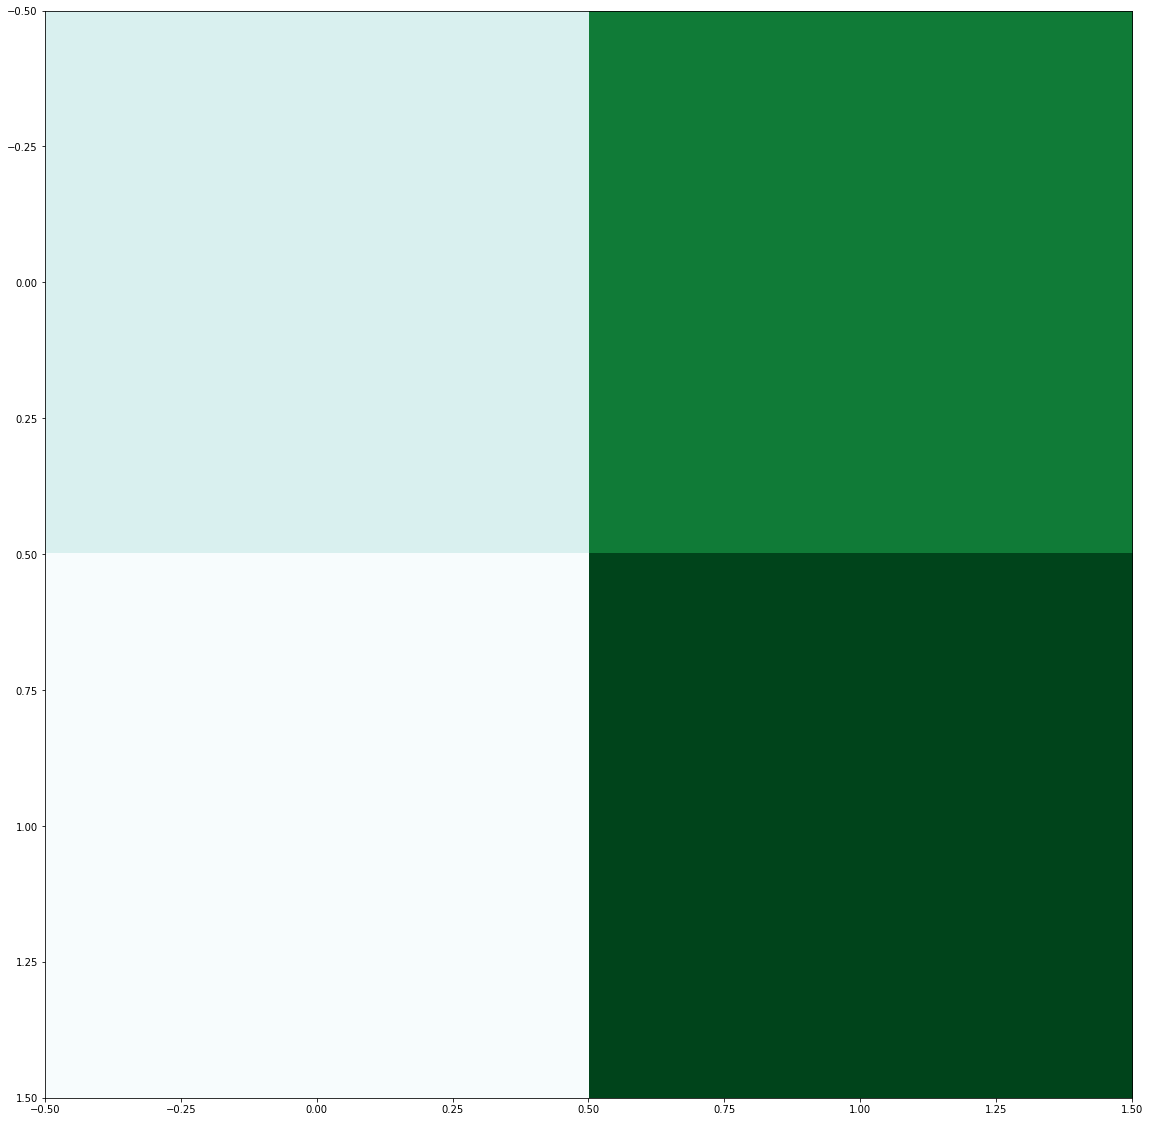

In [49]:
plt.imshow(mu_conf_mats[1], cmap="BuGn")

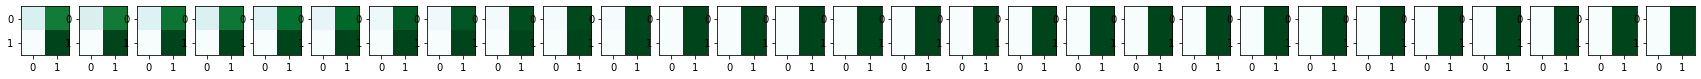

In [50]:
plt.rcParams['figure.figsize'] = [30, 20]
fig, ax = plt.subplots(nrows=1, ncols=num_mus)

for i in range(len(ax)):
    ax[i].imshow(mu_conf_mats[i], cmap="BuGn")
    

In [51]:
"""
Load Data
"""
#conf_file_dir = "/media/data/sbulusu/datasets/complexworm/dat_files/"
conf_file_dir = "/media/data/sbulusu/datasets/complexworm/dat_files/"
file_format_list = ["Multi_lattice_open_worms/open_configs-200-10*.dat",
                    "Multi_lattice_closed_worms/configs-200-10*.dat"
                   ]

#label_names = ["n", "phi2"]
label_names = []
labels_in_file_name = ["nt", "nx", "eta", "lambda", "mu"]

dataset = open_worm_lat_dataset_load_new_lightning_dat.kl_dataset(conf_file_dir, file_format_list,
                                                              label_names, labels_in_file_name,
                                                              transform=None)

found file 58 paths:
['/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.965.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.975.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.910.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.915.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.025.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.980.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.925.dat', '/media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.050.dat', '/media/da

Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.965.dat
['open_configs', '200', '10', '4.010', '1.000', '0.965']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.965.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.965.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs


first example loaded:
{'conf': tensor([[[ 1,  1,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  1],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  1,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[-1,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0, -1],
         [ 0,  0,  0,  ...,  0,  0, -1],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0, -1,  ...,  0,  0,  0],
         [ 0,  0, -1,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  1,  0,  0],
         [ 0,  1,  0,  ...,  0,  0,  0]],

        [[ 1,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  1,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
     


Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.910.dat
['open_configs', '200', '10', '4.010', '1.000', '0.910']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.910.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.910.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.915.dat
['open_configs', '200', '10', '4.010', '1.000', '0.915']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.915.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.915.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.025.dat
['open_configs', '200', '10', '4.010', '1.000', '1.025']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.025.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.025.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.980.dat
['open_configs', '200', '10', '4.010', '1.000', '0.980']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.980.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.980.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.925.dat
['open_configs', '200', '10', '4.010', '1.000', '0.925']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.925.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.925.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.050.dat
['open_configs', '200', '10', '4.010', '1.000', '1.050']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.050.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.050.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.045.dat
['open_configs', '200', '10', '4.010', '1.000', '1.045']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.045.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.045.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.990.dat
['open_configs', '200', '10', '4.010', '1.000', '0.990']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.990.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.990.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.030.dat
['open_configs', '200', '10', '4.010', '1.000', '1.030']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.030.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.030.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.955.dat
['open_configs', '200', '10', '4.010', '1.000', '0.955']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.955.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.955.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.950.dat
['open_configs', '200', '10', '4.010', '1.000', '0.950']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.950.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.950.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.920.dat
['open_configs', '200', '10', '4.010', '1.000', '0.920']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.920.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.920.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.945.dat
['open_configs', '200', '10', '4.010', '1.000', '0.945']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.945.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.945.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.930.dat
['open_configs', '200', '10', '4.010', '1.000', '0.930']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.930.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.930.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.960.dat
['open_configs', '200', '10', '4.010', '1.000', '0.960']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.960.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.960.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.995.dat
['open_configs', '200', '10', '4.010', '1.000', '0.995']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.995.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.995.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.040.dat
['open_configs', '200', '10', '4.010', '1.000', '1.040']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.040.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.040.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.935.dat
['open_configs', '200', '10', '4.010', '1.000', '0.935']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.935.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.935.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.020.dat
['open_configs', '200', '10', '4.010', '1.000', '1.020']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.020.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.020.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.035.dat
['open_configs', '200', '10', '4.010', '1.000', '1.035']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.035.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.035.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.970.dat
['open_configs', '200', '10', '4.010', '1.000', '0.970']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.970.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.970.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.000.dat
['open_configs', '200', '10', '4.010', '1.000', '1.000']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.000.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.000.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.005.dat
['open_configs', '200', '10', '4.010', '1.000', '1.005']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.005.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.005.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.985.dat
['open_configs', '200', '10', '4.010', '1.000', '0.985']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.985.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.985.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.940.dat
['open_configs', '200', '10', '4.010', '1.000', '0.940']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.940.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-0.940.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.010.dat
['open_configs', '200', '10', '4.010', '1.000', '1.010']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.010.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.010.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.015.dat
['open_configs', '200', '10', '4.010', '1.000', '1.015']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.015.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_open_worms/open_configs-200-10-4.010-1.000-1.015.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-200-10-4.010-1.000-0.945.dat
['configs', '200', '10', '4.010', '1.000', '0.945']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-200-10-4.010-1.000-0.945.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-200-10-4.010-1.000-0.945.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-200-10-4.010-1.000-0.925.dat
['configs', '200', '10', '4.010', '1.000', '0.925']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-200-10-4.010-1.000-0.925.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-200-10-4.010-1.000-0.925.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-200-10-4.010-1.000-0.970.dat
['configs', '200', '10', '4.010', '1.000', '0.970']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-200-10-4.010-1.000-0.970.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-200-10-4.010-1.000-0.970.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-200-10-4.010-1.000-0.975.dat
['configs', '200', '10', '4.010', '1.000', '0.975']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']
First read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-200-10-4.010-1.000-0.975.dat with size :torch.Size([4000, 4, 10, 200])
Read conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-200-10-4.010-1.000-0.975.dat with size :torch.Size([4000, 4, 10, 200])
Loading 4000 confs



Processing conf file /media/data/sbulusu/datasets/complexworm/dat_files/Multi_lattice_closed_worms/configs-200-10-4.010-1.000-0.950.dat
['configs', '200', '10', '4.010', '1.000', '0.950']
loaded file name labels ['nt', 'nx', 'eta', 'lambda', 'mu']



RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 256000000 bytes. Error code 12 (Cannot allocate memory)


In [ ]:
target_attributes = ["open"]
output_attributes = target_attributes

dataset.train_label_names = target_attributes

In [ ]:
net = best_model

In [ ]:
lat_size = dataset[0][0].size()[1:]

In [ ]:
new_data_len = len(dataset)
test_indices = list(range(new_data_len))

lat_size = dataset[0][0].size()[1:]

"""
Load Test Data
"""
net = best_model
net.eval()
print(f"test dataset size: {len(test_indices)}")
#lat_size = [10,200]
input_size = net.input_size
output_size = net.output_size
model_input_shape = tuple(np.concatenate(([-1],input_size)))
print(model_input_shape)

#net_outputs = np.zeros( (len(test_indices)) )
net_outputs = np.zeros( (len(test_indices), len(output_attributes)) )
#labels = np.zeros( (len(test_indices)) )
labels = np.zeros( (len(test_indices), len(output_attributes)) )
mus = np.zeros( (len(test_indices)) )

with torch.no_grad():
    for i in tqdm(range(len(test_indices))):
    #for i in tqdm(range(len(val_indices))):

        test_index = test_indices[i]
        conf_lat_links, label = dataset[test_index]
        batch_conf_lat_links = torch.zeros(1, *conf_lat_links.size())
        batch_conf_lat_links[0] = conf_lat_links
        mus[i] = dataset.data[test_index]["mu"]
        #net_outputs[i] = net(conf_lat_links.view(model_input_shape).to(device).float()).detach().cpu().numpy()
        #net_outputs[i] = net(conf_lat_links.to(device).float()).detach().cpu().numpy()
        net_outputs[i] = net(batch_conf_lat_links.to(device).float()).detach().cpu().numpy()
        #output = net(conf_lat_links.view(model_input_shape).float())
        #labels[i] = label.detach().cpu().numpy()
        labels[i] = np.array(label)
 

In [ ]:
labels = labels.flatten()
net_outputs = net_outputs.flatten()

In [ ]:
dev = np.abs(net_outputs - labels)
print(dev.sum())

In [ ]:
int_net_outputs = np.rint(net_outputs)
int_dev = np.abs(int_net_outputs - labels.astype(int))

In [ ]:
results = pd.DataFrame(np.transpose([labels.flatten(), int_net_outputs.flatten()]))

In [ ]:
results

In [ ]:
results.describe()

In [ ]:
pd_labels = pd.Series(labels.flatten(), name="Label")
pd_int_net_outputs = pd.Series(int_net_outputs.flatten(), name="Pred")
pd.crosstab(pd_labels, pd_int_net_outputs)

In [ ]:
print(f"lat_size {lat_size}")
for i in range(len(target_attributes)):
    print(f"misclassifications")
    print(np.sum(int_dev))

In [ ]:
 """confmat"""
import sklearn as sk

conf_mat = sk.metrics.confusion_matrix(labels, int_net_outputs)
#conf_mat = conf_mat/len(labels)
print(conf_mat)
plt.imshow(conf_mat, cmap="BuGn")

In [ ]:
 """confmat per mu"""

In [ ]:
unique_mus = np.unique(mus)
num_mus = len(unique_mus)
print(num_mus)

In [ ]:
mu_labels = []
mu_int_net_outputs = []
mu_conf_mats = []

In [ ]:
for mu_val in unique_mus:
    mu_loc = np.where(mus == mu_val)[0]
    
    mu_label = labels[mu_loc]
    mu_int_net_output = int_net_outputs[mu_loc]
    
    mu_labels.append(mu_label)
    mu_int_net_outputs.append(mu_int_net_output)
    mu_conf_mat = sk.metrics.confusion_matrix(mu_label, mu_int_net_output)
    mu_conf_mats.append(mu_conf_mat)
    
for mu_i in range(num_mus):
    print(mu_conf_mats[mu_i])
    print("\n")

In [ ]:
plt.imshow(mu_conf_mats[1], cmap="BuGn")

In [ ]:
plt.rcParams['figure.figsize'] = [30, 20]
fig, ax = plt.subplots(nrows=1, ncols=num_mus)

for i in range(len(ax)):
    ax[i].imshow(mu_conf_mats[i], cmap="BuGn")
    